In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return 3*x**2 - 4*x +5

In [6]:
f(3.0)

20.0

In [7]:
xs = np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [8]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

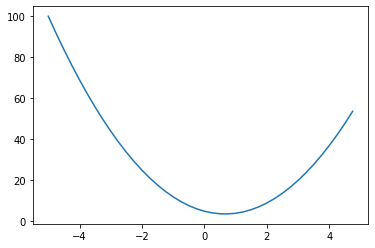

In [11]:
plt.plot(xs, ys);

In [20]:
h = 0.0000001
x = 2/3
(f(x+h) - f(x))/h

2.9753977059954195e-07

In [22]:
# More complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [25]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


### Variable Class

In [229]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Empty function
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only support int/float powers"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad 
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self/other
        return self * other**-1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other): #self - other:
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [127]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [139]:
a = Value(2.0)
2 * a

Value(data=4.0)

### Draw Dot

In [274]:
#Expression graph visualization
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        # print(v)
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # Left to Right graph

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph create a recyangular record node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name= uid + n._op, label = n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1,n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

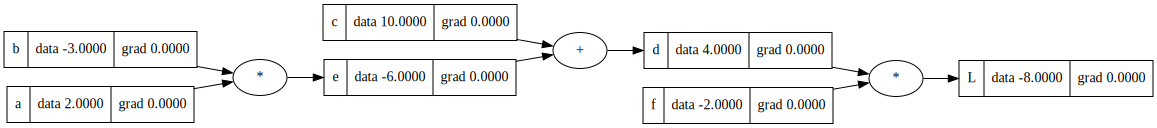

In [61]:
draw_dot(L)

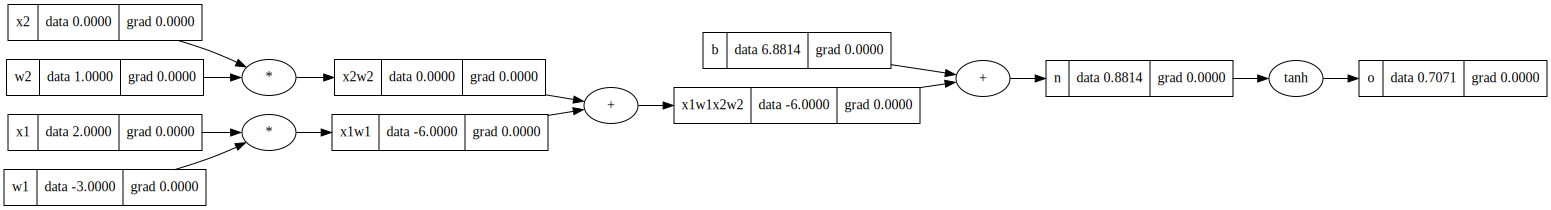

In [92]:
# More complicated, a Neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2 of neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of newuron
b = Value(6.8813735870185432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

draw_dot(o)

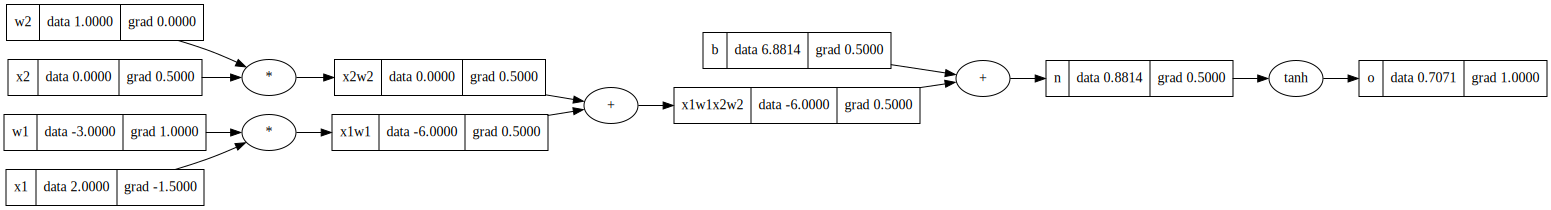

In [87]:
draw_dot(o)

### This is us calling _backward manually

In [80]:
o.grad = 1.0
o._backward()

In [82]:
n._backward()

In [84]:
b._backward()
x1w1x2w2._backward()

In [86]:
x2w2._backward()
x1w1._backward()

### And here's how it's done with topologocal sort

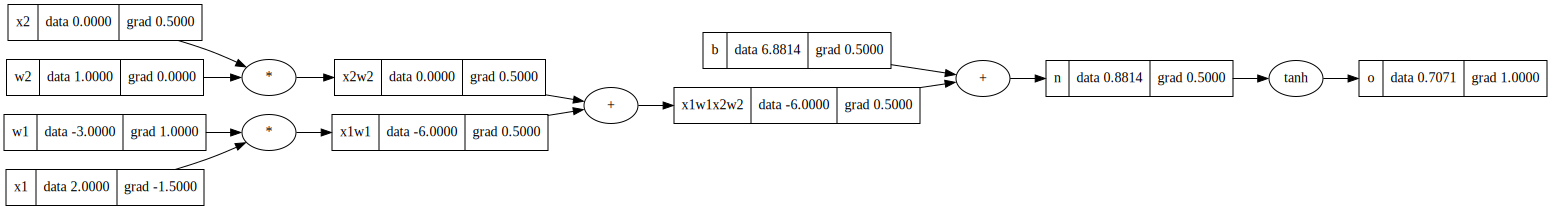

In [90]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

### We want the above functionality to be hidden within our Value class

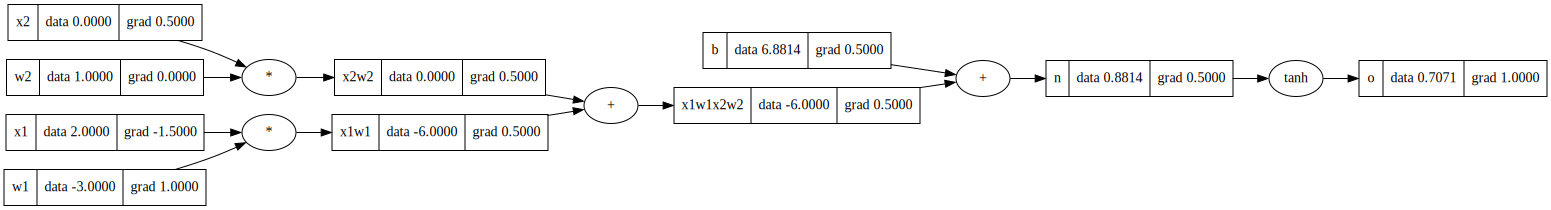

In [93]:
o.backward()
draw_dot(o)

### There is a bug here

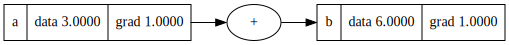

In [95]:
### There is an issue anytime a variable is used more than once, it's all wrong
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

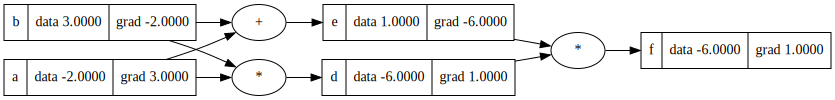

In [96]:
# Also wrong here
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

### The solution is for the gradient to accumulate in the Value instead of it being set

Use `x.grad += ...`

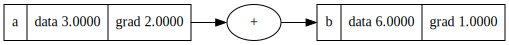

In [98]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

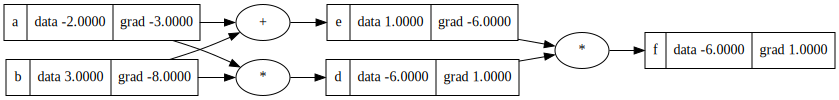

In [99]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

### Tanh in peices

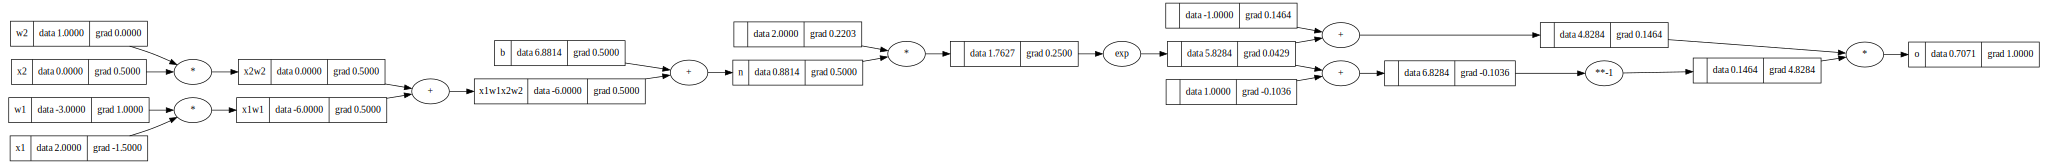

In [231]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870185432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'

# ---
# o = n.tanh(); o.label='o'
# ---
# redefine o by doing tanh in peices

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

### Doing the same in PyTorch

In [233]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True 
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True 
b = torch.Tensor([6.8813735870185432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Making a Multi-Layer Perceptron

In [275]:
import random
from typing import Any
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for i in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w*x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x, verbose=False):
        for layer in self.layers:
            # if verbose:
            #     print('-------------------------------')
            #     print(x)
            #     for neuron in layer.neurons:
            #         print(neuron.w, neuron.b)
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x, True)

Value(data=0.10688714080744448)

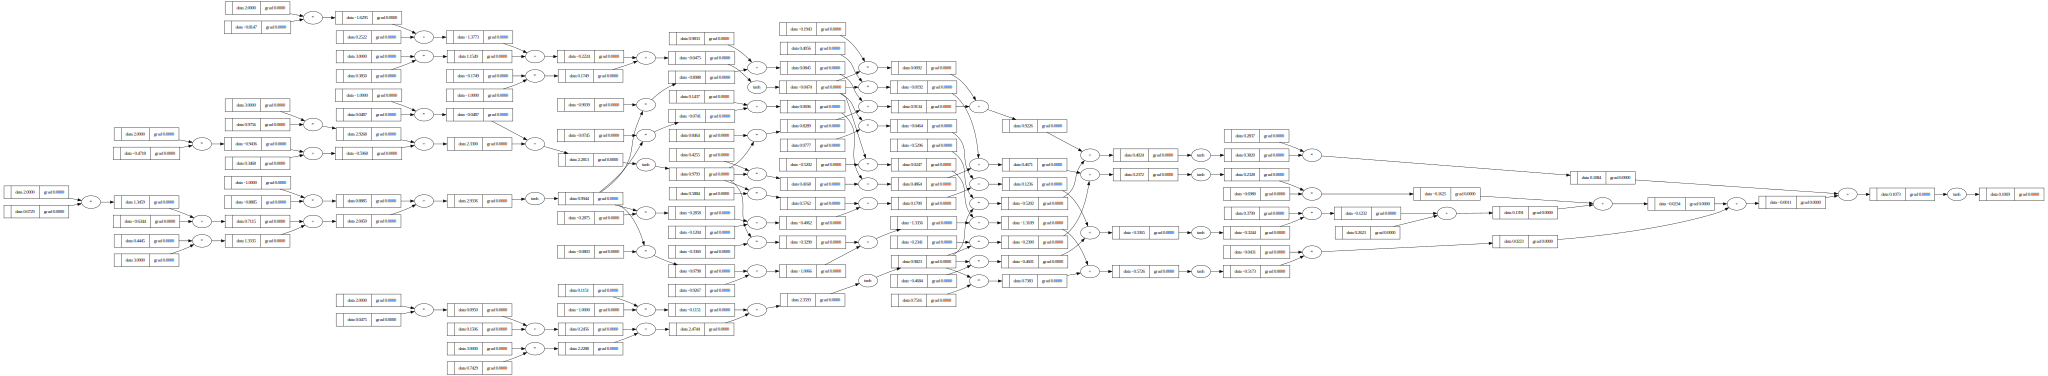

In [276]:
draw_dot(n(x))